In [1]:
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mp
import io
import requests
import itertools
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import sys
from array import array
from VBSAnalysis.EventIterator import EventIterator
import argparse
from sklearn import metrics
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.model_selection import KFold
from scipy import interp

ModuleNotFoundError: No module named 'ROOT'

In [3]:
def Dataset_Creator(f, cuts):
    
    def momcons(evento, j):
        l = []
        mom = (evento.muon + evento.neutrino).Pt()
        for i in (range(len(evento.jets))):
            if evento.jets[i] != j:
                l.append(abs(mom-(evento.jets[i]+j).Pt()))
        l = sorted(l)
        return l[0]



    def inbetweenD(getti, j):
        inb = 0
        for i in (range(len(getti))):
            if getti[i] != j:
                if math.sqrt((getti[i].X()-j.X())**2 + (getti[i].Y()-j.Y())**2 + (getti[i].Z()-j.Z())**2) < 100:
                    inb += 1

        return inb


    def inbetweenR(getti, j):
        inb = 0
        for i in (range(len(getti))):
            if getti[i] != j:
                if j.DeltaR(getti[i]) < 2:
                    inb += 1

        return inb


    def nearW(getti, j):
        l = []
        for i in (range(len(getti))):
            if getti[i] != j:
                l.append(abs(80-(getti[i]+j).M()))

        l = sorted(l)
        return l[0]

    def MaxM(getti, j):
        l = []
        for i in (range(len(getti))):
            if getti[i] != j:
                l.append((getti[i]+j).M())
        l = sorted(l, reverse = True)
        return l[0]

    def Maxdeltaeta(getti, j):
        l = []
        for i in (range(len(getti))):
            if getti[i] != j:
                l.append(abs(getti[i].Eta()-j.Eta()))
        l = sorted(l, reverse = True)
        return l[0]

    def Mindeltaeta(getti, j):
        l = []
        for i in (range(len(getti))):
            if getti[i] != j:
                l.append(abs(getti[i].Eta()-j.Eta()))
        l = sorted(l)
        return l[0]

    def MinR(getti, j):
        l = []
        for i in (range(len(getti))):
            if getti[i] != j:
                l.append(j.DeltaR(getti[i]))
        l = sorted(l)
        return l[0]

    def MaxR(getti, j):
        l = []
        for i in (range(len(getti))):
            if getti[i] != j:
                l.append(j.DeltaR(getti[i]))
        l = sorted(l, reverse = True)
        return l[0]

    def size(getti, j):
        distance = []
        for i in (range(len(getti))):
            if getti[i] != j:
                distance.append([j.DeltaR(getti[i]) , math.sqrt((getti[i].X()-j.X())**2 + (getti[i].Y()-j.Y())**2 + (getti[i].Z()-j.Z())**2) ])
        distance = sorted(distance, key = itemgetter(1))

        return distance[0][0]

    def distance_nearest(getti, j):

        distance = []
        for i in (range(len(getti))):
            if getti[i] != j:
                #distance.append(math.sqrt((getti[i].X()-j.X())**2 + (getti[i].Y()-j.Y())**2 + (getti[i].Z()-j.Z())**2) )
                distance.append(j.DeltaR(getti[i]))
        distance = sorted(distance)

        return distance[0]

    def nearest_Pt(getti, j):

        distance = []
        for i in (range(len(getti))):
            if getti[i] != j:
                distance.append([ i, j.DeltaR(getti[i])])

        distance = sorted(distance, key = itemgetter(1))

        return getti[distance[0][0]].Pt()

    def min_deltaeta(getti, j):

        distance = []
        for i in (range(len(getti))):
            if getti[i] != j:
                distance.append([ i, j.DeltaR(getti[i]) ])
        distance = sorted(distance, key = itemgetter(1))

        return getti[distance[0][0]].Eta()

    def min_deltaphi(getti, j):

        distance = []
        for i in (range(len(getti))):
            if getti[i] != j:
                distance.append([ i, j.DeltaR(getti[i])])
        distance = sorted(distance, key = itemgetter(1))

        return getti[distance[0][0]].Phi()
    
    def variable_list(evento, j):
        totaljet = evento.njets
        pts = [j.Pt() for j in evento.jets]
        etas = [abs(j.Eta()) for j in evento.jets]
        ms = [j.M() for j in evento.jets]
        maxpt = max(pts)
        minpt = min(pts)
        maxm = max(ms)
        minm = min(ms)
        W = nearW(evento.jets, j)
        Maxjj = MaxM(evento.jets,j)
        distance = distance_nearest(evento.jets, j)
        Mindelta= Maxdeltaeta(evento.jets, j)
        Maxdelta=Mindeltaeta(evento.jets, j)
        inb = inbetweenR(evento.jets, j)
        inbd = inbetweenD(evento.jets,j)
        near_Pt = nearest_Pt(evento.jets, j)
        MinDR = MinR(evento.jets, j)
        MaxDR= MaxR(evento.jets, j)
        if evento.paired_parton(j) == None:
            return [ totaljet, MinDR, Maxdelta,  W, Maxjj, near_Pt, maxm, minm, maxpt, minpt , j.Pt(), j.E(), distance, inb, inbd, 0]
        else:
            return [ totaljet, MinDR, Maxdelta,  W, Maxjj, near_Pt, maxm, minm, maxpt, minpt , j.Pt(), j.E(), distance, inb, inbd, 1]
        
        
    nevent = 0 
    for evento in EventIterator(f,criteria = cuts, pairing = True):
            nevent += 1
            for j in evento.jets:
                variables = []
                variab = variable_list(evento, j)
                variables.append(variab)
                
                
    return np.array(variables)

In [6]:
def to_xy(df, target):
    y = df[:,target]
    x = np.delete(df, target, 1)
    return x,y

In [7]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    #soglia per contrasto colore
    thresh = cm.max() / 1.5 
    #plotto per ogni cella della matrice il valore corrispondente
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    #plotto il resto
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=0)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def Normalizer(y):
    mean = np.mean(y)
    std = np.std(y)
    z = []
    for i in y:
        z.append((i-mean)/std)
    z = np.array(z)
    return z

In [ ]:
def acc_plotter(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['acc'], label = "train_accuracy")
    plt.plot(history.history['val_acc'], label="val_accuracy")
    plt.legend(['acc_train', 'acc_test'], loc='lower right')
    plt.xlabel('epochs')
    plt.ylabel('acc')

def loss_plotter(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label = "train_loss")
    plt.plot(history.history['val_loss'], label="val_loss")
    plt.legend(['loss_train', 'loss_test'], loc='upper right')
    plt.xlabel('epochs')
    plt.ylabel('loss')

# Prova

In [4]:
f = r.TFile(<path-to-.root>, "OPEN")
   
cuts = [
    ("pt_min_muon", 20),
    ("eta_max_muon", 2.1),
    ("pt_min_jets", 30),
    ("eta_max_jets", 4.7),
    ("eq_flag", 0),
    ("min_njets",4),
    ("atleastone_mjj_M", 250),
    ]
data = Dataset_Creator(f, cuts)
x,y = to_xy(data, data.shape[1]-1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
print(class_weights)

[3.44435287 0.5849083 ]


In [ ]:
#Normalizing dataset

scaler = StandardScaler(copy = False, with_mean = True, with_std = True)
scaler.fit(x_train)
scaler.fit_transform(x_train)
scaler.fit(x_test)
scaler.fit_transform(x_test)
y_train = Normalizer(y_train)
y_test = Normalizer(y_test)

print("X_train shape, Y_train shape: {}, {}".format(x_train.shape, y_train.shape))
print("X_test shape, Y_test shape: {}, {}".format(x_test.shape, y_test.shape))

In [5]:
model = Sequential()
model.add(Dense(50, input_dim = x_train.shape[1], activation = 'relu' ))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation= 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='auto')
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,epochs=10, class_weight=class_weights, callbacks = [early_stop])

Train on 936121 samples, validate on 234031 samples
Epoch 1/10
936121/936121 [==============================] - 27s 28us/step - loss: 0.3677 - val_loss: 0.3518
Epoch 2/10
936121/936121 [==============================] - 26s 28us/step - loss: 0.3499 - val_loss: 0.3503
Epoch 3/10
936121/936121 [==============================] - 28s 30us/step - loss: 0.3479 - val_loss: 0.3478
Epoch 4/10
936121/936121 [==============================] - 28s 30us/step - loss: 0.3470 - val_loss: 0.3498
Epoch 5/10
936121/936121 [==============================] - 28s 30us/step - loss: 0.3465 - val_loss: 0.3473
Epoch 6/10
936121/936121 [==============================] - 28s 30us/step - loss: 0.3463 - val_loss: 0.3470
Epoch 7/10
936121/936121 [==============================] - 28s 30us/step - loss: 0.3463 - val_loss: 0.3477
Epoch 8/10
936121/936121 [==============================] - 27s 29us/step - loss: 0.3463 - val_loss: 0.3473
Epoch 9/10
936121/936121 [==============================] - 26s 27us/step - loss: 0.

2018-08-28 22:47:15.053570: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [ ]:
pred = np.rint(model.predict(x_test))
score = metrics.accuracy_score(y_test, pred)
print("Final accuracy: {}".format(score))
print("auc score: {}".format(roc_auc_score(y_test, pred)))
mp.rc('figure', figsize=(10,8), dpi=140)
fp , tp, th = roc_curve(y_test, pred)
plt.plot(fp, tp, 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve AUC: %.2f' % roc_auc_score(y_test, pred))

In [ ]:
acc_plotter(history)

In [ ]:
loss_plotter(history)

Not normalized confusion matrix
[[  1739  32463]
 [  1339 198490]]


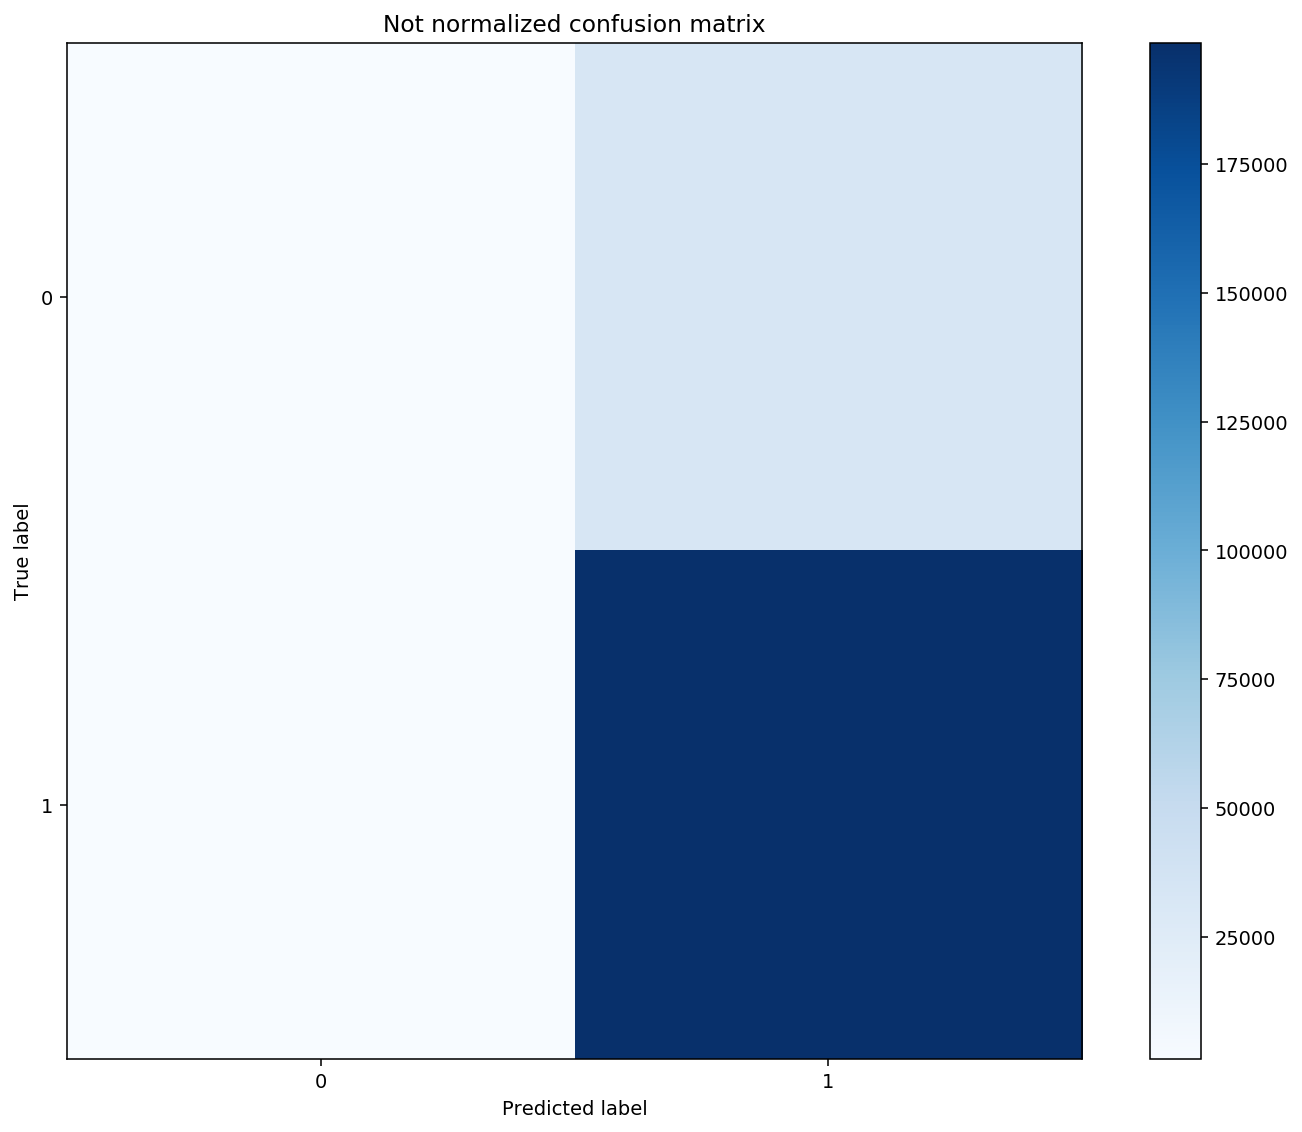

Normalized confusion matrix
[[0.05 0.95]
 [0.01 0.99]]


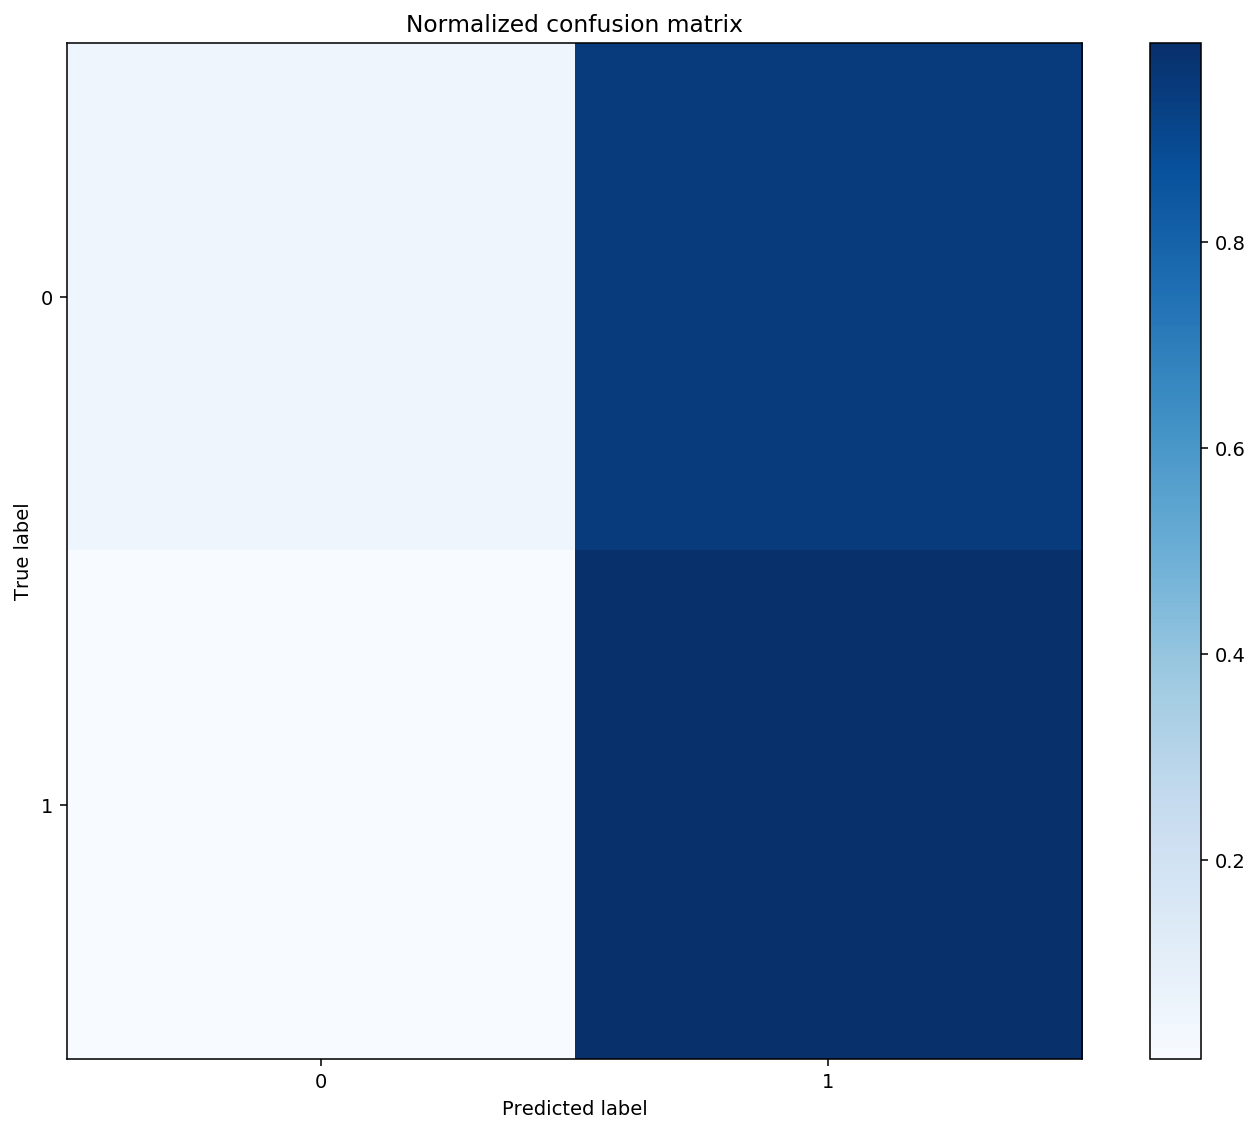

In [10]:
cm = confusion_matrix(y_test, pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized,[0,1], title='Normalized confusion matrix')
plt.show()

# Prova KFold

In [9]:
data = np.load('dataset.npy')
x,y = to_xy(data, 10)
#y = to_categorical(y)
#x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=42)
class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)
print(class_weights)
kf = KFold(5)

[3.45573783 0.58458125]


Fold #1
Train on 374132 samples, validate on 93533 samples
Epoch 1/10
374132/374132 [==============================] - 14s 37us/step - loss: 0.3877 - val_loss: 0.3517
Epoch 2/10
374132/374132 [==============================] - 13s 34us/step - loss: 0.3530 - val_loss: 0.3514
Epoch 3/10
374132/374132 [==============================] - 13s 33us/step - loss: 0.3505 - val_loss: 0.3490
Epoch 4/10
374132/374132 [==============================] - 12s 32us/step - loss: 0.3493 - val_loss: 0.3481
Epoch 5/10
374132/374132 [==============================] - 13s 34us/step - loss: 0.3485 - val_loss: 0.3490
Epoch 6/10
374132/374132 [==============================] - 13s 34us/step - loss: 0.3480 - val_loss: 0.3478
Epoch 7/10
374132/374132 [==============================] - 12s 32us/step - loss: 0.3478 - val_loss: 0.3467
Epoch 8/10
374132/374132 [==============================] - 13s 34us/step - loss: 0.3476 - val_loss: 0.3502
Epoch 9/10
374132/374132 [==============================] - 12s 33us/step - l

OSError: Unable to create file (unable to open file: name = '/modelli_giacomo/PrimoKFold5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

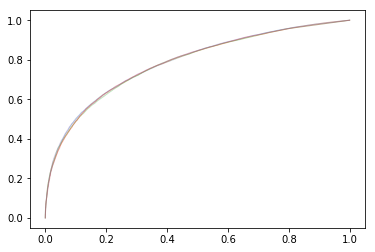

In [13]:
oos_y = []
oos_pred = []
fold = 0
tps = []
aucs = []
mean_fp = np.linspace(0, 1, 100)
for train,test in kf.split(x):
    fold+=1
    print("Fold #{}".format(fold))
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    model = Sequential()
    model.add(Dense(50, input_dim = x.shape[1], activation = 'relu' ))
    model.add(Dense(30, activation = 'relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1, activation= 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=5, verbose=1, mode='auto')
#checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
    model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,epochs=10, batch_size=32, class_weight=class_weights)
#model.fit(x_train, y_train, verbose=1, epochs=10, batch_size=32, class_weight=class_weights)
    predi = model.predict(x_test)
    oos_y.append(y_test)
    oos_pred.append(predi)
    fp , tp, th = roc_curve(y_test, predi)
    tps.append(interp(mean_fp, fp, tp))
    tps[-1][0] = 0.0
    roc_auc = roc_auc_score(y_test, predi)
    aucs.append(roc_auc)
    plt.plot(fp, tp, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.3f)' % (fold, roc_auc))  
model.save("/modelli_giacomo/PrimoKFold5")    
mp.rc('figure', figsize=(10,8), dpi=140)
fig0 = plt.gcf()
plot_roc_curve_KFold(tps, mean_fp, aucs)
plt.figure(figsize=(20,20))
plt.show()
plt.draw()
fig0.savefig("images/roc_PJAssoc.png")
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

In [14]:
print(aucs)

[0.7858873062945431, 0.7843785900364233, 0.7835060466882365, 0.7845014863548939, 0.7870601072893544]


In [15]:
pred1 = np.rint(oos_pred)
score = metrics.accuracy_score(oos_y, pred1)
print("Final accuracy: {}".format(score))
print("auc score: {}".format(roc_auc_score(oos_y, oos_pred)))
#mp.rc('figure', figsize=(10,8), dpi=140)
#fp , tp, th = roc_curve(y_test, pred)
#plt.plot(fp, tp, 'r')
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('roc curve')

ValueError: Classification metrics can't handle a mix of multiclass-multioutput and unknown targets

Not normalized confusion matrix
[[  1559  66106]
 [  1268 398732]]


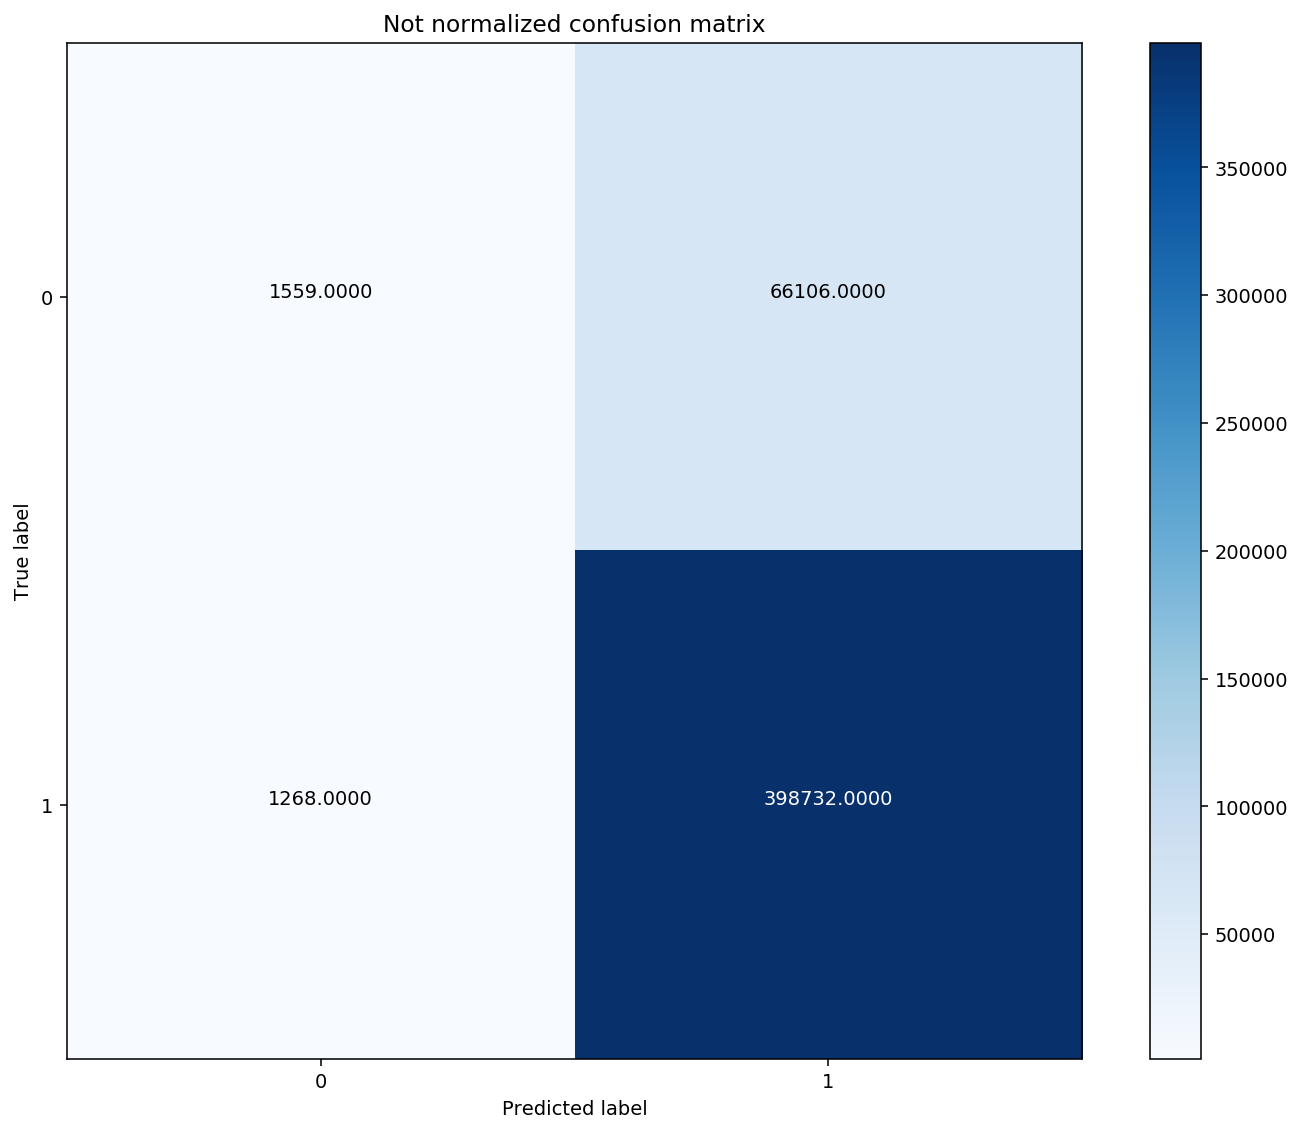

Normalized confusion matrix
[[0.02 0.98]
 [0.   1.  ]]


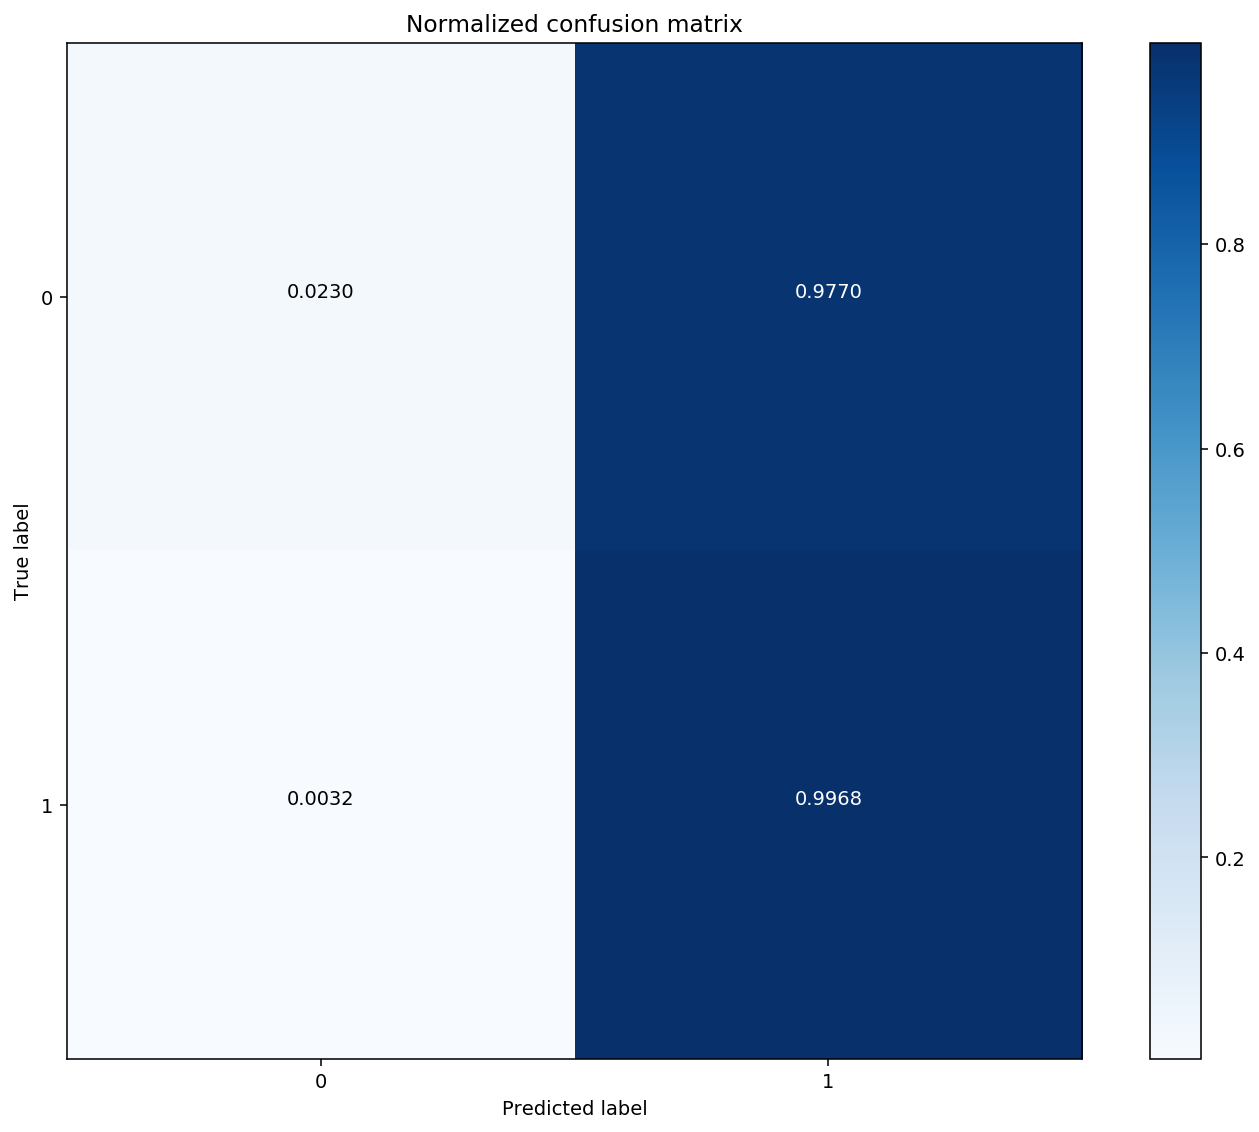

<Figure size 1400x1120 with 0 Axes>

In [40]:
mp.rc('figure', figsize=(10,8), dpi=140)
cm = confusion_matrix(oos_y, pred1)
print('Not normalized confusion matrix')
print(cm)
fig = plt.gcf()
plot_confusion_matrix(cm,[0,1], title='Not normalized confusion matrix')
plt.show()
plt.draw()
fig.savefig("images/nonorm.png")
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
fig1 = plt.gcf()
plot_confusion_matrix(cm_normalized,[0,1], title='Normalized confusion matrix')
plt.show()
plt.draw()
fig1.savefig("images/norm.png")

In [22]:
h= []
string= np.array([0.1, 0.2, 0.9, 0.7, 0.8, 0.4])
print(len(string))

while i<len(string):
    if string[i]>0.7:
        string[i]=1;
    else:
        string[i]=0;
    i=i+1
print(string)

6
[0.1 0.2 0.9 0.7 0.8 0.4]
